## Figure 2.D
### Venn diagram showing the shared and unique sites between RNA002 U-to-C, RNA004 U-to-C and Dorado Ψ with at least 20% reported modification occupancy (or 20% U-to-C mismatch percentage) after intersecting all sites for valid coverage of 20 reads.

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import sys
import time
import pickle
import os.path as osp
import tqdm
import pysam
import seaborn as sns
from matplotlib_venn import venn3, venn2

#### First intersect 3, then filter for 20%

In [4]:
modkit_df = pd.read_csv('08_07_24_R9RNA_GM12878_mRNA_RT_sup_8mods_polyA_sorted_filtered.chr12-112000000-114000000_modkit_ivt_correct.tsv', sep='\t')

modkit_df.columns = [
    "chrom", "start_position", "end_position", "modified_base_code", "score", 
    "strand", "start_position_compat", "end_position_compat", "color", 
    "Nvalid_cov", "fraction_modified", "Nmod", "Ncanonical", "Nother_mod", 
    "Ndelete", "Nfail", "Ndiff", "Nnocall", "ivt_correct"
]
## fitering for >= 20 reads coverage
modkit_df = modkit_df[modkit_df["score"] >= 20]

## filtering for Psi mod code
modkit_df = modkit_df[modkit_df['modified_base_code'].astype(str) == "17802"]

df = pd.read_csv('merged_2_4_T2C_A2G.csv', sep='\t')

df['mismatch_perc2'] = np.where(df['ref_2'] == 'T_2', df['C_perc_2'], df['G_perc_2'])
df['mismatch_perc4'] = np.where(df['ref_4'] == 'T_4', df['C_perc_4'], df['G_perc_4'])

In [6]:
print("Before filtering:")
modkit = modkit_df[modkit_df['modified_base_code'].astype(str) == "17802"]
print(f"modkit: {len(modkit)} rows")
print(f"RNA002 (mismatch_perc2): {len(df)} rows")
print(f"RNA004 (mismatch_perc4): {len(df)} rows")

Before filtering:
modkit: 15127 rows
RNA002 (mismatch_perc2): 28907 rows
RNA004 (mismatch_perc4): 28907 rows


In [7]:
modkit_positions = set(zip(modkit['chrom'], modkit['end_position']))

df_positions = set(zip(df['chrom'], df['pos']))

common_positions = modkit_positions & df_positions

df = df[df[['chrom', 'pos']].apply(tuple, axis=1).isin(common_positions)].reset_index(drop=True)

print(f"Number of rows after intersecting with modkit: {len(df)}")

Number of rows after intersecting with modkit: 13893


In [10]:
modkit_positions = set(zip(modkit['chrom'], modkit['end_position']))
rna002_positions = set(zip(df['chrom'], df['pos']))
rna004_positions = set(zip(df['chrom'], df['pos']))

common_positions = modkit_positions & rna002_positions & rna004_positions

In [11]:
modkit = modkit[modkit[['chrom', 'end_position']].apply(tuple, axis=1).isin(common_positions)].reset_index(drop=True)

df_filtered = df[df[['chrom', 'pos']].apply(tuple, axis=1).isin(common_positions)].reset_index(drop=True)

rna002 = df_filtered[['chrom', 'pos', 'mismatch_perc2']].copy()
rna004 = df_filtered[['chrom', 'pos', 'mismatch_perc4']].copy()

print("\nAfter filtering:")
print(f"modkit: {len(modkit)} rows")
print(f"RNA002 (mismatch_perc2): {len(rna002)} rows")
print(f"RNA004 (mismatch_perc4): {len(rna004)} rows")


After filtering:
modkit: 13893 rows
RNA002 (mismatch_perc2): 13893 rows
RNA004 (mismatch_perc4): 13893 rows


In [12]:
## filter for >= 20% ratio
modkit_filtered = modkit[modkit['fraction_modified'] >= 20.0]
rna002_filtered = rna002[rna002['mismatch_perc2'] >= 0.2]
rna004_filtered = rna004[rna004['mismatch_perc4'] >= 0.2]

In [13]:
modkit_positions = set(zip(modkit_filtered['chrom'], modkit_filtered['end_position']))
rna002_positions = set(zip(rna002_filtered['chrom'], rna002_filtered['pos']))
rna004_positions = set(zip(rna004_filtered['chrom'], rna004_filtered['pos']))

overlap_all = modkit_positions & rna002_positions & rna004_positions
overlap_modkit_rna002 = modkit_positions & rna002_positions
overlap_modkit_rna004 = modkit_positions & rna004_positions
overlap_rna002_rna004 = rna002_positions & rna004_positions

print(f"Total positions in RNA002: {len(rna002_positions)}")
print(f"Total positions in RNA004: {len(rna004_positions)}")
print(f"Total positions in Modkit: {len(modkit_positions)}")
print(f"Positions in all three conditions: {len(overlap_all)}")
print(f"Positions in RNA002 and RNA004: {len(overlap_rna002_rna004)}")
print(f"Positions in RNA002 and Modkit: {len(overlap_modkit_rna002)}")
print(f"Positions in RNA004 and Modkit: {len(overlap_modkit_rna004)}")

Total positions in RNA002: 20
Total positions in RNA004: 0
Total positions in Modkit: 5
Positions in all three conditions: 0
Positions in RNA002 and RNA004: 0
Positions in RNA002 and Modkit: 0
Positions in RNA004 and Modkit: 0


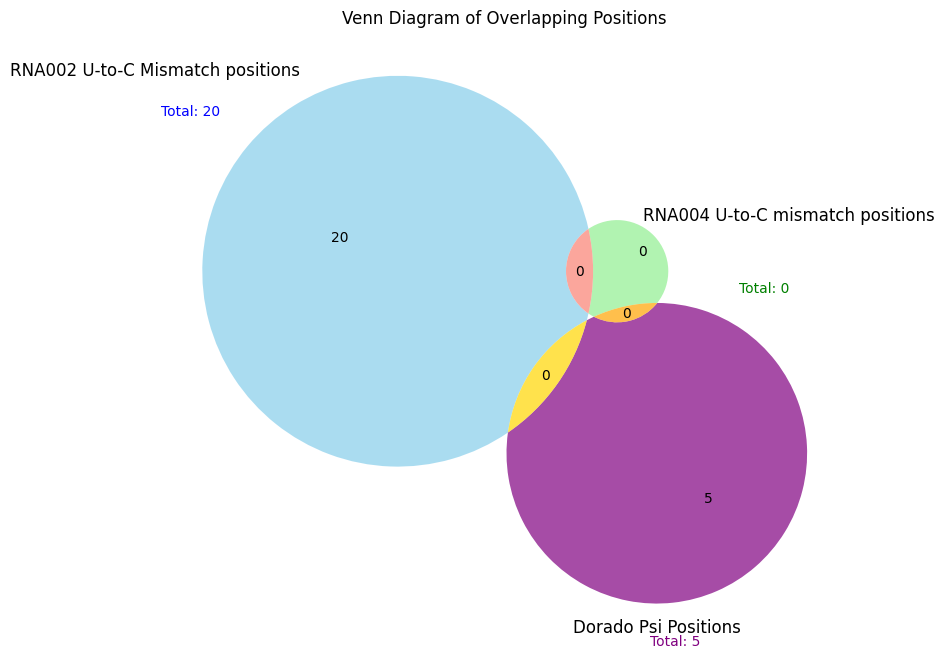

In [15]:
# 3 way Venn diagram

plt.figure(figsize=(10, 8))

#Abc, aBc, ABc, abC, AbC, aBC, ABC"
from matplotlib_venn.layout.venn3 import DefaultLayoutAlgorithm
layout_algorithm=DefaultLayoutAlgorithm(fixed_subset_sizes=(75, 4.2, .67 , 44, 1.37, 0.07,.36))
venn = venn3([rna002_positions, rna004_positions, modkit_positions],
             ('RNA002 U-to-C Mismatch positions', 'RNA004 U-to-C mismatch positions', 'Dorado Psi Positions'),
            layout_algorithm=layout_algorithm)

for patch, color in zip(venn.patches, ['skyblue', 'lightgreen', 'salmon', 'purple', 'gold', 'orange', 'gray']):
    if patch:
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

plt.text(-0.7, 0.5, f"Total: {len(rna002_positions)}", color='blue', ha='center')
plt.text(0.6, 0.1, f"Total: {len(rna004_positions)}", color='green', ha='center')
plt.text(0.4, -0.70, f"Total: {len(modkit_positions)}", color='purple', ha='center')

plt.title('Venn Diagram of Overlapping Positions')

plt.show()